# Signal/Background Classification using Boosted Decision Trees

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, f1_score
import helper_function_module_BDT as hfm
from tqdm import tqdm
import os
from sklearn.inspection import permutation_importance

SEED = 763210
np.random.seed(SEED)

In [3]:
import os
print(os.getcwd())

/teamspace/studios/this_studio/all/BDT


## 1. Data Loading

In [4]:
signal = hfm.load_json_data("../txt_data_preprocess/only2bj_only1p/ppzaxbba_ax75_200k_minpt20_13jets_only2bj_only1p_processed.json")
background = hfm.load_json_data("../txt_data_preprocess/only2bj_only1p/bg_500k_minpt20_13jets_only2bj_only1p_processed.json")

Loading event data from ../txt_data_preprocess/only2bj_only1p/ppzaxbba_ax75_200k_minpt20_13jets_only2bj_only1p_processed.json...
--- Successfully loaded 4706 events :)
Loading event data from ../txt_data_preprocess/only2bj_only1p/bg_500k_minpt20_13jets_only2bj_only1p_processed.json...
--- Successfully loaded 1835 events :)


In [5]:
signal[23]

{'eventno': 908,
 'jets': [{'jet_index': 1,
   'Eta': 0.0975329,
   'Phi': -1.86384,
   'pT': 41.0557,
   'Px': -11.8595,
   'Py': -39.3055,
   'Pz': 4.01063,
   'E': 41.2511,
   'btag': 1},
  {'jet_index': 2,
   'Eta': -0.848129,
   'Phi': 1.39594,
   'pT': 34.254,
   'Px': 5.95894,
   'Py': 33.7317,
   'Pz': -32.6622,
   'E': 47.3303,
   'btag': 1}],
 'photons': [{'isophoton_index': 1,
   'Eta': 0.364949,
   'Phi': -1.07091,
   'pT': 13.8627,
   'Px': 6.64479,
   'Py': -12.1664,
   'Pz': 5.17222,
   'E': 14.7961}],
 'num_btag_jets': 2,
 'num_isophoton': 1}

In [6]:
signal_df= hfm.prepare_data_for_model(signal, required_jets=2, required_photons=1, event_label = 1)

if signal_df is not None:
    print("\n--- Data Shapes Before Splitting ---")
    print(f"Signal DF shape: {signal_df.shape}")

background_df= hfm.prepare_data_for_model(background, required_jets=2, required_photons=1, event_label = 0)

if background_df is not None:
    print("\n--- Data Shapes Before Splitting ---")
    print(f"Background DF shape: {background_df.shape}")

Processing 4706 events to extract features...


Extracting Features: 100%|██████████| 4706/4706 [00:00<00:00, 20181.27it/s]



--- Data Shapes Before Splitting ---
Signal DF shape: (4706, 4)
Processing 1835 events to extract features...


Extracting Features: 100%|██████████| 1835/1835 [00:00<00:00, 27707.15it/s]


--- Data Shapes Before Splitting ---
Background DF shape: (1835, 4)


In [7]:
signal_df.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,event_label
24,13.0306,3.256088,104.684121,1
56,17.3783,3.092898,117.432975,1
73,15.4209,3.074344,86.364580,1
110,13.0771,2.439503,183.648980,1
146,16.3563,2.648339,79.765753,1


In [8]:
background_df.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,event_label
469,19.0611,3.003889,123.591138,0
526,23.2127,3.174227,96.376148,0
726,19.3143,3.050558,126.535614,0
842,38.1033,2.969569,146.501946,0
1087,11.3399,3.184644,151.961832,0


In [9]:
data = pd.concat([signal_df, background_df], axis = 0)

In [10]:
data = data.sample(frac=1, random_state = SEED)
data.head()

,isophoton_pT,deltaR_jet12,invMass_2j1p,event_label
61158,26.1648,2.050675,132.373251,1
100395,33.4167,2.074865,111.941783,0
228168,33.5561,3.571706,174.547992,0
155862,11.1213,2.641193,78.529258,1
248743,15.5981,3.163017,83.717150,0


In [11]:
X, y = data.iloc[:,:-1].values, data.loc[:,'event_label'].values.astype(int)

In [12]:
X.shape

(6541, 3)

## 2. Train Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=SEED,
                                                   stratify = y)

print("\n--- Data Shapes After Splitting ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


--- Data Shapes After Splitting ---
X_train shape: (5232, 3)
X_test shape: (1309, 3)
y_train shape: (5232,)
y_test shape: (1309,)


# Gradient Boosting Classifier

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

In [19]:
param_grid_grad = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

In [20]:
grid_search_grad = GridSearchCV(GradientBoostingClassifier(random_state=SEED),
                          param_grid=param_grid_grad,
                          cv=5,
                          n_jobs=-1)

In [21]:
grid_search_grad.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=763210),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [50, 100, 200]})

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


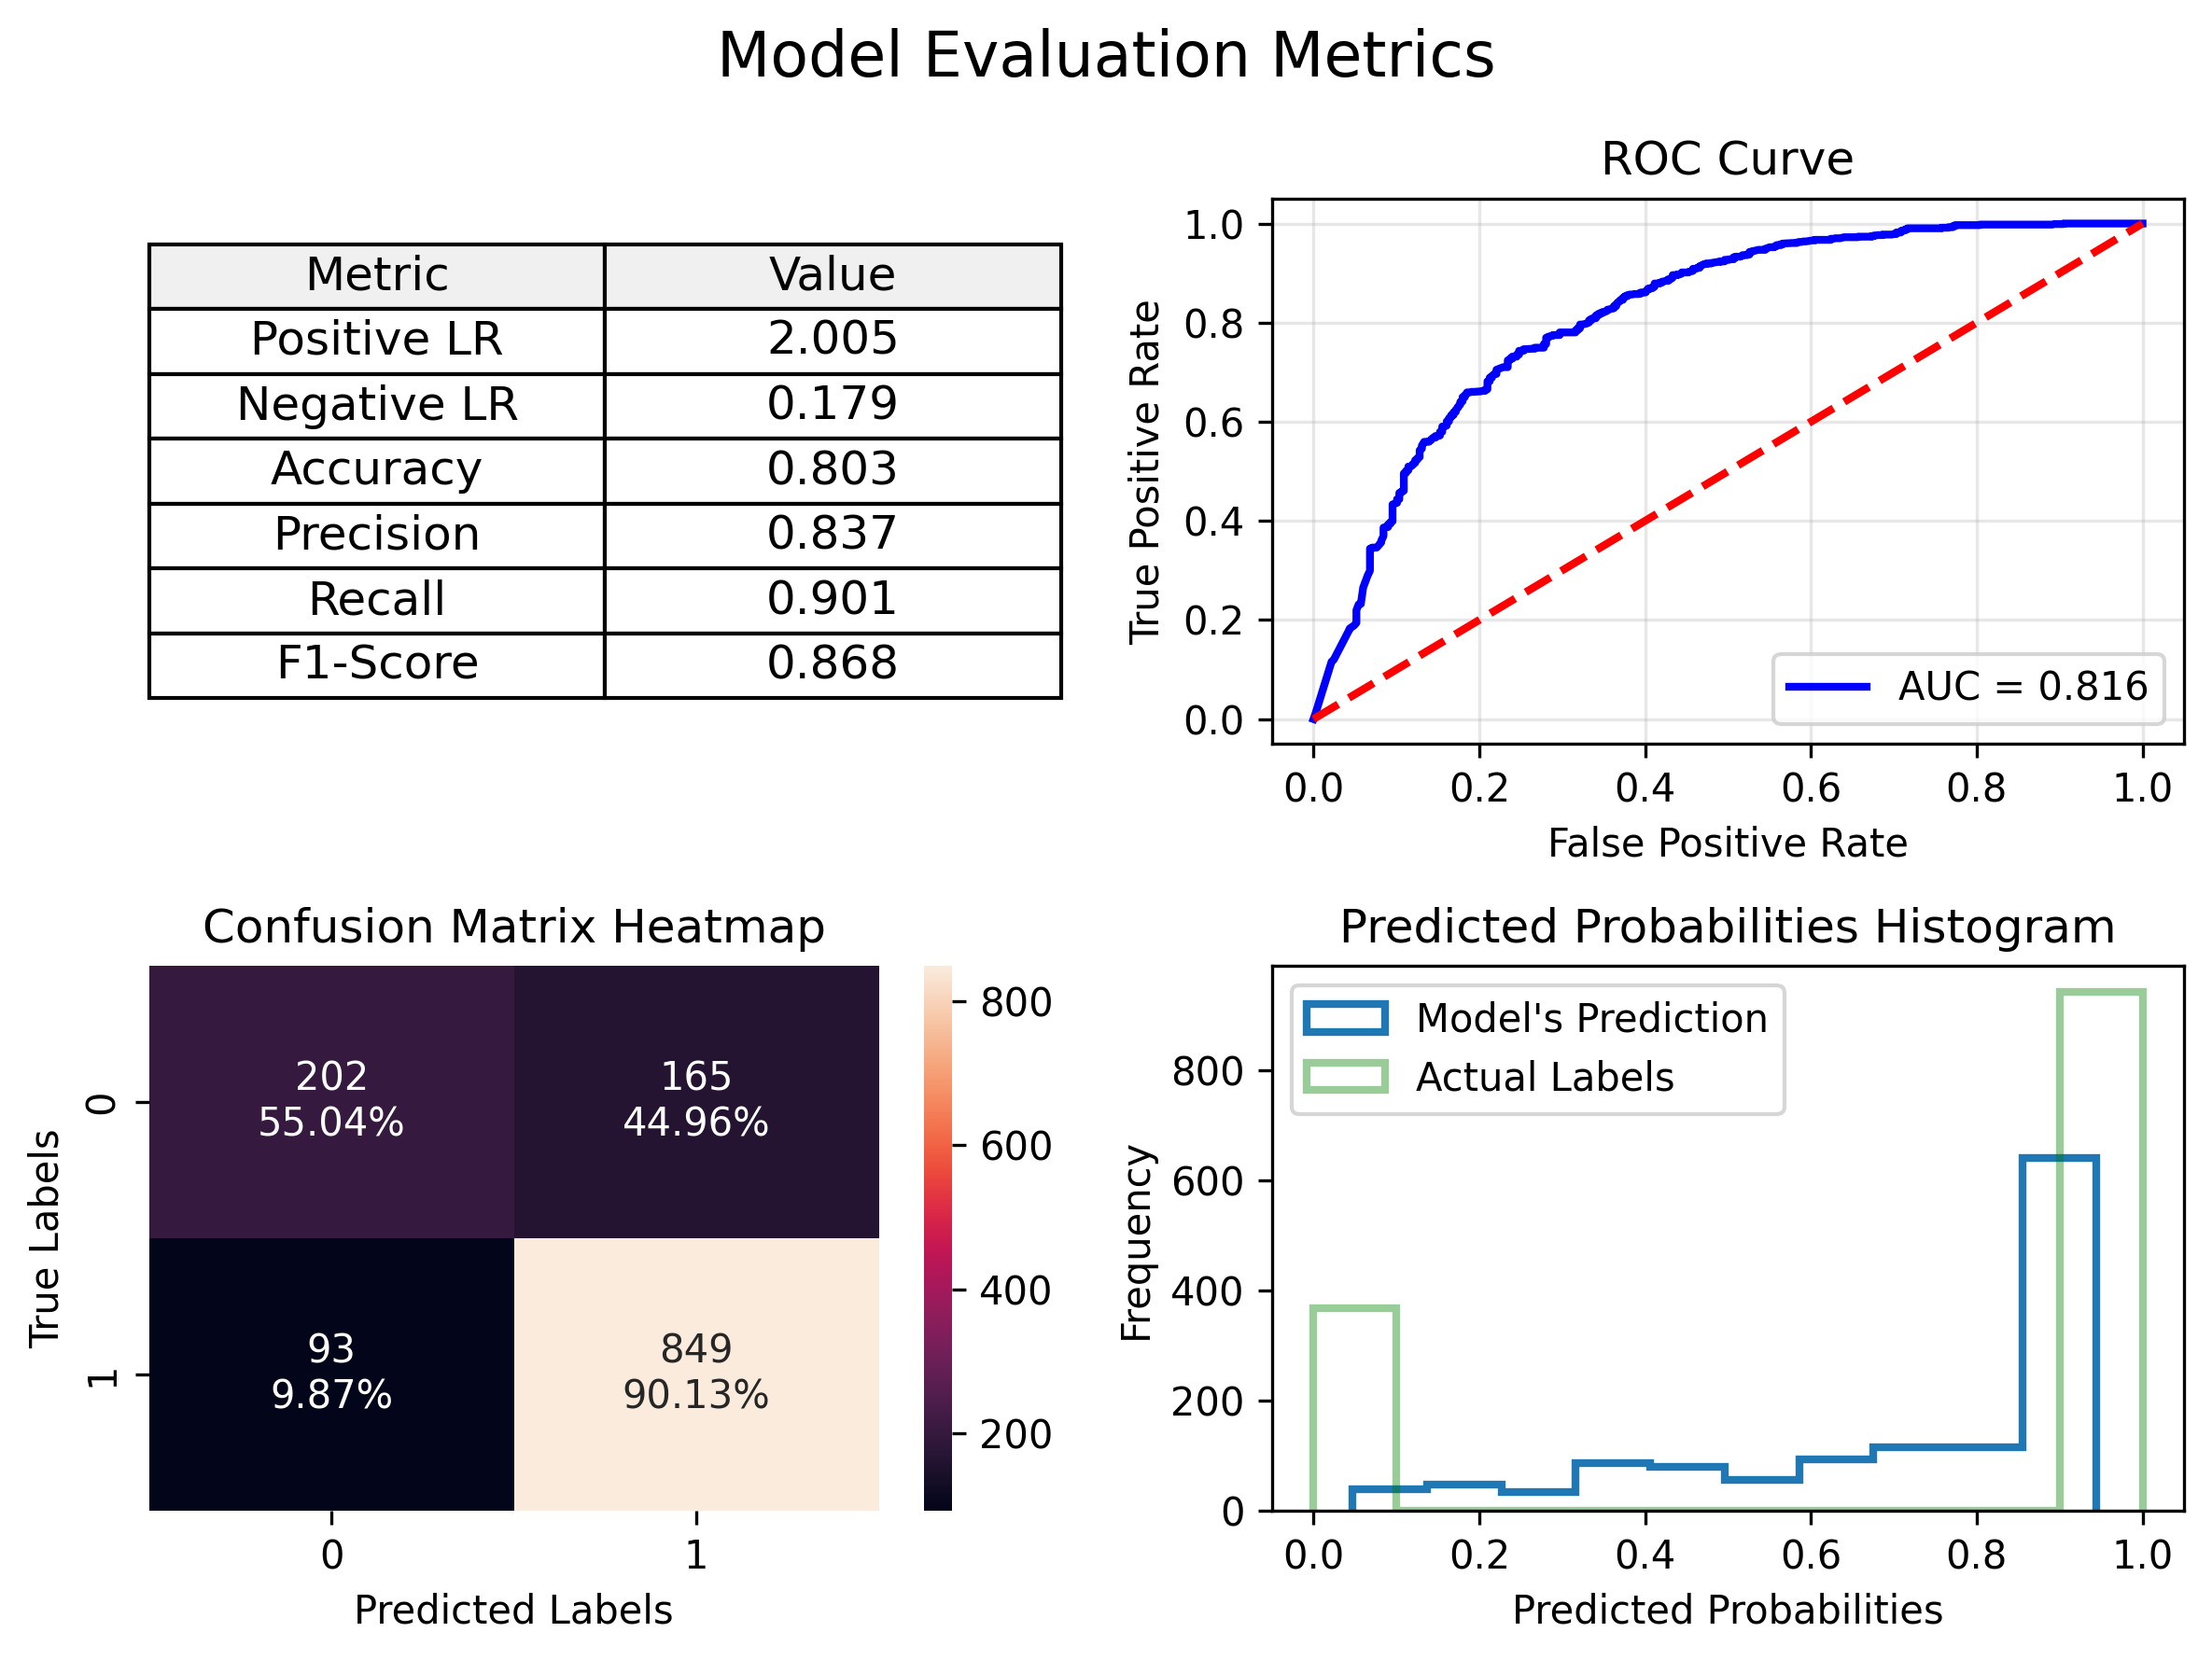

In [22]:
best_model_gb = grid_search_grad.best_estimator_
y_pred_gb = best_model_gb.predict(X_test)
y_pred_prob_gb = best_model_gb.predict_proba(X_test)[:, 1] #For getting probabilites of class label 1

print(f'Best Hyperparameters: {grid_search_grad.best_params_}')

y_pred_label_gb = [1 if (y_prob >= 0.5) else 0 for y_prob in y_pred_prob_gb]
hfm.eval_model(y_test, y_pred_prob_gb, y_pred_label_gb, save_fig = False, save_fig_path = 'ax75_GBEval_Metrics.png')

In [28]:
features_col = data.columns[:-1]

# Feature Importance - GradientBoost


--- Calculating Impurity-Based Feature Importance (MDI) ---
invMass_2j1p    0.707937
deltaR_jet12    0.146443
isophoton_pT    0.145620
dtype: float64


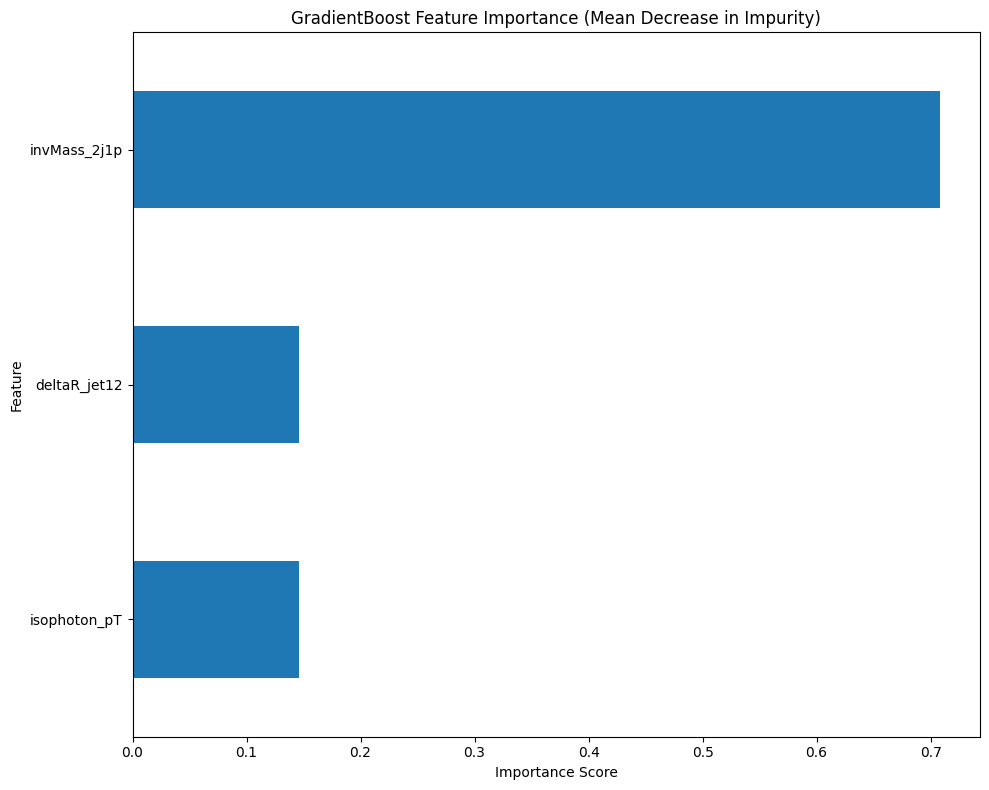

In [26]:
print("\n--- Calculating Impurity-Based Feature Importance (MDI) ---")
# Get importance scores directly from the trained model
gb_importances_mdi = best_model_gb.feature_importances_

# Create a Pandas Series for easy handling and sorting
gb_importances_mdi = pd.Series(gb_importances_mdi, index=features_col)
gb_importances_mdi = gb_importances_mdi.sort_values(ascending=False)

print(gb_importances_mdi)

# --- Visualize MDI Importances ---
plt.figure(figsize=(10, 8))
gb_importances_mdi.plot(kind='barh')
plt.title("GradientBoost Feature Importance (Mean Decrease in Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()

## Permutation Importance - GradientBoost


--- Calculating Permutation Importance (on Test Set) ---

Features Permutation Importance on Test Set, metric='roc_auc'):
invMass_2j1p    0.135023
deltaR_jet12    0.048283
isophoton_pT    0.036233
dtype: float64


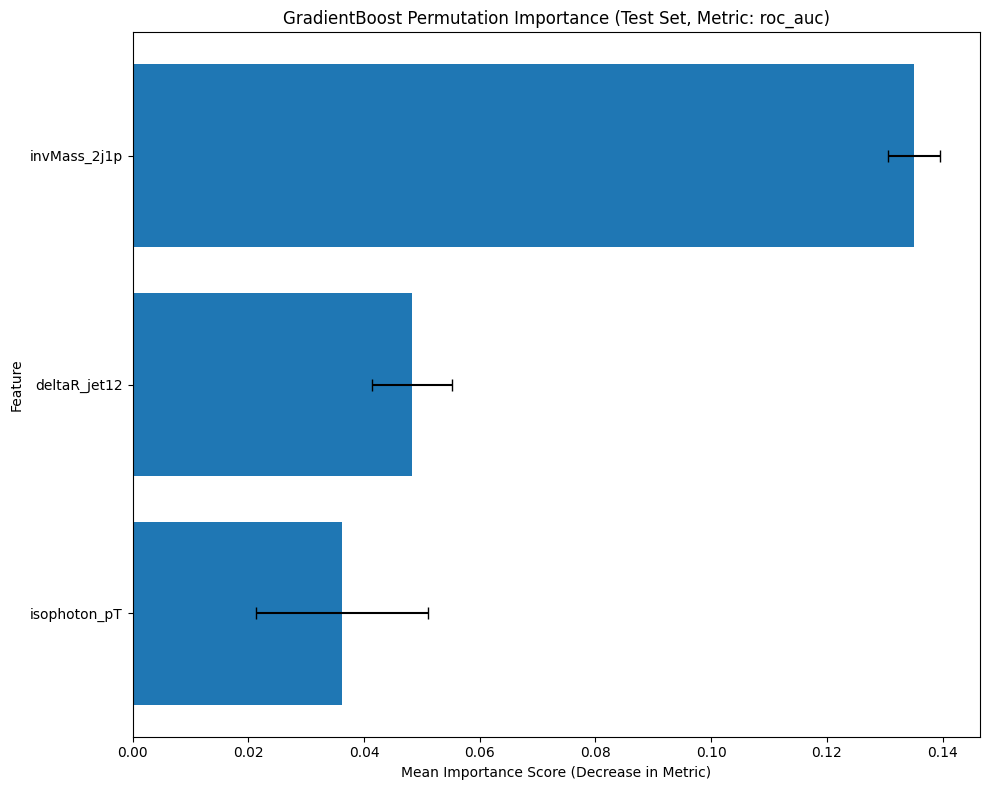

In [32]:
print("\n--- Calculating Permutation Importance (on Test Set) ---")


# Choose a scoring metric - accuracy, roc_auc, f1, balanced_accuracy etc.
# For imbalanced data, 'roc_auc', 'f1_weighted', or 'balanced_accuracy' are often better than 'accuracy'
scoring_metric = 'roc_auc'

# Calculate permutation importance
# n_repeats: Number of times to shuffle each feature for stability
gb_perm_importance_result = permutation_importance(
    estimator=best_model_gb,
    X=X_test,
    y=y_test,
    scoring=scoring_metric,
    n_repeats=10, # Increase for more stable results, but slower
    random_state=SEED,
    n_jobs=-1 # Use multiple cores if available
)

# Extract mean and standard deviation of importance scores
gb_importances_perm_mean = gb_perm_importance_result.importances_mean
gb_importances_perm_std = gb_perm_importance_result.importances_std

# Create a Pandas Series for easy handling
gb_perm_importances = pd.Series(gb_importances_perm_mean, index=features_col)
gb_perm_importances = gb_perm_importances.sort_values(ascending=False)

print(f"\nFeatures Permutation Importance on Test Set, metric='{scoring_metric}'):")
print(gb_perm_importances)

# --- Visualize Permutation Importances ---
plt.figure(figsize=(10, 8))
# Get sorted indices for plotting std deviations correctly
sorted_idx = gb_perm_importances.index
plt.barh(sorted_idx, gb_perm_importances[sorted_idx],
         xerr=gb_importances_perm_std[gb_perm_importances.index.get_indexer(sorted_idx)], # Map std dev to sorted order
         capsize=4)
plt.title(f"GradientBoost Permutation Importance (Test Set, Metric: {scoring_metric})")
plt.xlabel("Mean Importance Score (Decrease in Metric)")
plt.ylabel("Feature")
plt.gca().invert_yaxis() # Display the most important feature at the top
plt.tight_layout()
plt.show()